# Machine Learning SoSe21 Practice Class

Dr. Timo Baumann, Dr. Özge Alaçam, Björn Sygo <br>
Email: baumann@informatik.uni-hamburg.de, alacam@informatik.uni-hamburg.de, 6sygo@informatik.uni-hamburg.de


## Exercise 5
**Description:** Implement adaboost <br>
**Deadline:** Saturday, 29. Mai 2021, 23:59 <br>
**Working together:** You can work in pairs or triples but no larger teams are allowed. <br>
&emsp;&emsp;&emsp; &emsp; &emsp; &emsp; &emsp; Please adhere to the honor code discussed in class. <br>
&emsp;&emsp;&emsp; &emsp; &emsp; &emsp; &emsp; All members of the team must get involved in understanding and coding the solution.

## Submission: 
**Christoph Brauer, Linus Geewe, Moritz Lahann**

*Also put high-level comments that should be read before looking at your code and results.*

## Goal
The goal of this exercise is to implement Boosting based on a very simple base classifier.

You implementation should be sufficiently generic to <strong>handle an arbitrary number of dimensions</strong>.

### Choose your data

**Task 1** (10%): Choose and load your data.

For this exercise, you can choose between multiple datasets.
Choose either `dataCircle.txt`, which contains 2-dimensional points with the corresponding class label. The first 40 rows contain positive examples with the label 1 and the other 62 rows have negative examples with the label -1.
Alternatively, you may find it more interesting to use the features you extracted in the previous tasks from faces (you may use your own features, or use the feature computations from the sample solution). 
It will be more interesting to use the full set of faces, not just the small subset. 
(However, you may want to limit visualizations to 2 dimensions.)

Your implementation of the classifier shall not be limited to a fixed number of feature dimensions (e.g., 2 as in `dataCircle.txt`, or 6 as in your previous work on face detection) but should work with any number of features. However, there's no need to implement the data loading / feature computation for both data sets.

Set aside some randomly selected data as evaluation set. Alternatively you may want to re-use k-fold crossvalidation as implemented before (or from a sample solution).

In [173]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

data = np.loadtxt('dataCircle.txt')
print(data.shape)

(102, 3)


#### Implement a simple classifier, implement weighted sample evaluation, and ensure that classifiers are (at least) "weak"

**Task 2** (30%):

Start by implementing a function that returns a simple <strong>decision stump</strong> classifier for training data and given sample weights (many of these weak classifiers will later be combined).
Standard AdaBoost searches for the best classifier in each step, by evaluating all possible classifiers in their performance on the weighted data and then choosing the one with the lowest weighted
error. The classifiers that are considered are the boundaries between two points that change classes.

In this task, you may also use a simple <strong>random decision boundary classifier </strong> that choses a random decision boundary in a randomly selected dimension of your data. (Full credit only if you implement the full AdaBoost approach to classifier selection.)

Implement an evaluation function that tests the quality of a classifier on a set of data using <strong>weighted accuracy</strong>.

A classifier with <50% accuracy is not a <strong>weak</strong> classifier. Remind yourself how you can build a weak binary classifier based on one with accuracy below 50%.

In [174]:
class DecisionStump():
    def __init__(self, data, weights, random_decision = False):
        self.threshold = 0
        self.feature_index = 0
        self.default_class = 1

        if random_decision:
            self.train_random(data, weights)
        else:
            self.train(data, weights)

    def train_random(self, data, weights):
        # choose a random feature from our data (data is in the shape of [Feature Feature ... Class])
        self.feature_index = random.randint(0, data.shape[1] - 2)

        # resample data using weights
        data = np.random.choice(data[:, self.feature_index], size=data.shape[0], replace=True, p=weights)

        # set a random decision boundary (within our data's possible range)
        self.threshold = random.uniform(np.min(data), np.max(data))

    # middle between weighted class means for best feature
    def train(self, data, weights):
        # accs = []
        # thresholds = []
        # nr_dimensions = data.shape[1] - 1
        # for dimension in range(nr_dimensions):
        #     m1 = self.weighted_class_mean(data, dimension, weights, 1)
        #     m2 = self.weighted_class_mean(data, dimension, weights, -1)
        #     self.feature_index = dimension

        #     # middle of class means
        #     self.threshold = abs(m1 - m2) / 2
        #     thresholds.append(self.threshold)
        #     acc, _ = self.eval(data, weights)
        #     accs.append(acc)
        
        # # find best performing feature
        # print(accs)
        # print(thresholds)
        # best_feature_index = np.argmax(np.array(accs))
        # self.feature_index = best_feature_index
        # self.threshold = thresholds[best_feature_index]
        self.feature_index = random.randint(0, data.shape[1] - 2)
        m1 = self.weighted_class_mean(data, self.feature_index, weights, 1)
        m2 = self.weighted_class_mean(data, self.feature_index, weights, -1)
        self.threshold = abs(m1 - m2) / 2
        
    def weighted_class_mean(self, data, dimension, weights, label):
        class_indices = np.argwhere(data[:, -1] == label)
        features = data[:, dimension]
        class_features = features[class_indices]
        class_weights = weights[class_indices]
        return np.mean(class_features * class_weights)

    def predict(self, sample):
        return self.default_class if sample[self.feature_index] > self.threshold else -1 * self.default_class

    def eval(self, data, weights):
        true_classes = data[:, -1]
        predicted_classes = [self.predict(sample) for sample in data]
        accuracy = np.sum(np.equal(true_classes, predicted_classes) * weights)
        # should be -1 for correctly classifed  and 1 for misclassified
        weights_classified = true_classes * predicted_classes * -1
        return accuracy, weights_classified

    def flip_classifier(self):
        self.default_class *= -1




#### AdaBoost

**Task 3** (30%): Use the previous function that creates weak classifiers to implement AdaBoost: 

Initialize weights, select weak classifier, compute alpha, reweigh samples, iterate.

If you use random decision boundaries for your weak classifiers, the classifier added in each iteration isn't optimal and you may need a high number of iterations until your algorithm performs well.

In [175]:
class AdaBoost():
    def __init__(self):
        self.classifiers = []
        self.classifier_weights = []
        self.weights = []
        self.no_weak_classifier = False
        self.training_errors = []
        self.eval_errors = []


    def train(self, training_data, eval_data, epochs, random_boundary):
        self.weights = np.array([1 / len(data)] * len(data))
        for ep in range(epochs):
            classifier = DecisionStump(data, self.weights, random_decision=random_boundary)
            acc, _ = classifier.eval(data, self.weights)
            if (acc < 0.5):
                classifier.flip_classifier()
            acc, _ = classifier.eval(data, self.weights)

            error = self.error_candidate(data, classifier)
            alpha = self.alpha(error)

            self.classifier_weights.append(alpha)
            self.classifiers.append(classifier)

            best_error, best_classifier = self.select_classifier(data)

            # stop unsuccessfully if no weak classifier
            if (self.no_weak_classifier):
                break

            alpha = self.alpha(best_error)
            _, classified_weights = best_classifier.eval(data, self.weights)
            self.weights = self.new_weights(alpha, classified_weights)

            self.training_errors.append(self.eval(training_data))

            self.eval_errors.append(self.eval(eval_data))

        return self.training_errors, self.eval_errors

    def select_classifier(self, data):
        errors = [self.error_candidate(data, classifier) for classifier in self.classifiers]
        min_error = min(errors)
        if (min_error > 0.5):
            self.no_weak_classifier = True
        min_classifier_index = errors.index(min_error)
        return min_error, self.classifiers[min_classifier_index]
            
    
    def error_candidate(self, data, classifier):
        sum = 0
        for sample, weight in zip(data, self.weights):
            predicted = classifier.predict(sample)
            if predicted != sample[-1]:
                sum += weight
        return sum


    def alpha(self, error):
        return 0.5 * math.log((1 - error) / error)


    def new_weights(self, alpha, classified_weights):
        new_weights = np.array([weight * math.exp(sign * alpha) for weight, sign in zip(self.weights, classified_weights)])
        return new_weights / np.sum(new_weights)


    def predict(self, data):
        # normalize classifier weights?
        y_pred = []
        for sample in data:
            predictions = np.array([classifier.predict(sample) for classifier in self.classifiers])
            y_pred.append(math.copysign(1.0, sum(predictions * np.array(self.classifier_weights))))
        return y_pred

    def eval(self, data):
        pred = self.predict(data)
        return np.sum(np.not_equal(data[:, -1], pred)) / len(data)

In [176]:
def accuracy(true, pred):
    sum = 0
    for index in range(len(true)):
        sum += true[index] == pred[index]
    return sum / len(true)

Final Accuracy on test set:  0.8


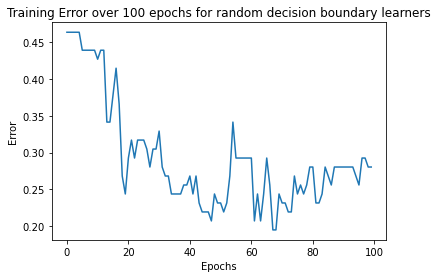

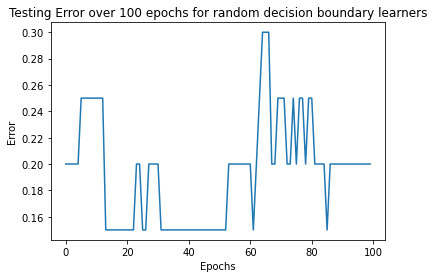

In [177]:
data = np.loadtxt('dataCircle.txt')
np.random.shuffle(data)
split_index = round(data.shape[0] * 0.8)
train = data[:split_index]
test = data[split_index:]

ensemble = AdaBoost()
training_errors, eval_errors = ensemble.train(train, test, 100, random_boundary=True)
pred = ensemble.predict(test)
acc = accuracy(test[:, -1], pred)
print("Final Accuracy on test set: ", acc)

plt.plot(range(len(training_errors)), training_errors)
plt.title(f"Training Error over {len(training_errors)} epochs for random decision boundary learners")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

plt.plot(range(len(eval_errors)), eval_errors)
plt.title(f"Testing Error over {len(eval_errors)} epochs for random decision boundary learners")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()


Final Accuracy on test set:  0.5


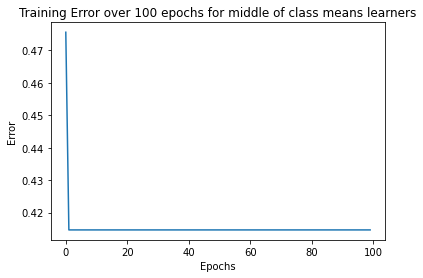

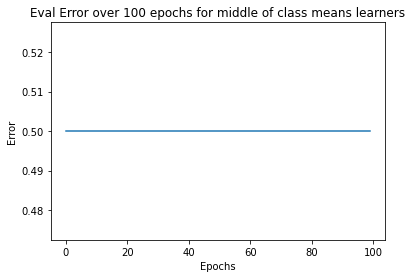

In [178]:
data = np.loadtxt('dataCircle.txt')
np.random.shuffle(data)
split_index = round(data.shape[0] * 0.8)
train = data[:split_index]
test = data[split_index:]

ensemble = AdaBoost()
training_errors, eval_errors = ensemble.train(train, test, 100, random_boundary=False)
pred = ensemble.predict(test)
acc = accuracy(test[:, -1], pred)
print("Final Accuracy on test set: ", acc)

plt.plot(range(len(training_errors)), training_errors)
plt.title(f"Training Error over {len(training_errors)} epochs for middle of class means learners")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

plt.plot(range(len(eval_errors)), eval_errors)
plt.title(f"Eval Error over {len(eval_errors)} epochs for middle of class means learners")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## Discussion of results

It's clear that the circle dataset is very simple (two dimensions, 80 training datapoints), which is probably why the ensemble classifier overfits so quickly even with the random decision boundary stumps as weak learners.

As for the results for the more "proper" adaboost method where a heuristic is used for the weak learners and the best feature is selected, there must be an error in our implementation because there is no change in performance. When selecting a random feature and using the heuristic, there is an error decrese for one epoch but none afterwards, and there are quickly no weak learners left. This is not the behaviour we would expect, so it's likely down to a mistake somewhere.

### Evaluate your classifier and plot its inner workings

**Task 4** (15%):

Evaluate your training set error, as well as evaluation set errors over the iterations. For this it may be convenient if your final weighted ensemble classifier that is trained via AdaBoost can be restricted to use only the first _m_ classifiers (and alphas) afterwards.

#### Plot decision boundary/areas

**Task 5** (15%):

(If you use face data: pick two relevant feature dimensions only for this subtask and use only a small subset of the training data if runtime becomes an issue.)

Plot the decisions taken by your classifier in one of the following ways (or both): 
 * plot the first, second and third decision boundaries chosen by AdaBoost in a succession of plots. Also, plot the training samples in a size that is proportional to their weight after the first, second and third decision those same plots. Explain how the weight changes influence the next iteration's behaviour.
 * decide on the resolution of your image matrix (e.g., use a resolution of 100 samples over the $x_1$ and the $x_2$ range of your data), record the decisions of your classifier for all $x_1$/$x_2$ coordinates and color the image's pixels according to the decision. Plot the image. Add the training data as colored points to the plot as well. You may consult the corresponding code in the sample solution for Softmax classification.

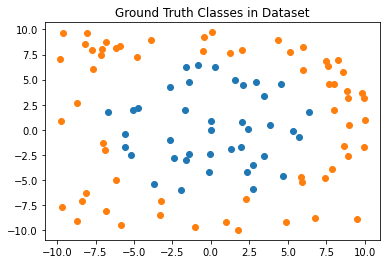

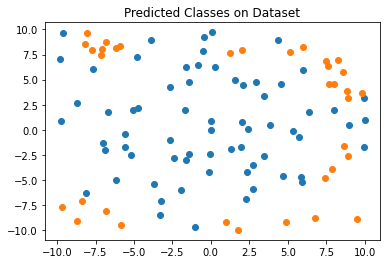

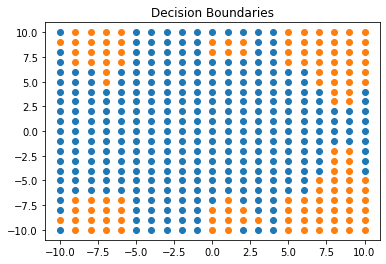

In [179]:
data = np.loadtxt('dataCircle.txt')
np.random.shuffle(data)
train = data
test = np.array(np.meshgrid(np.arange(-10, 11, 1), np.arange(-10, 11, 1))).T.reshape(-1, 2)

circle_data = data[data[:, -1] == 1]
plt.scatter(circle_data[:, 0], circle_data[:, 1])
non_circle_data = data[data[:, -1] == -1]
plt.scatter(non_circle_data[:, 0], non_circle_data[:, 1])
plt.title("Ground Truth Classes in Dataset")
plt.show()

ensemble = AdaBoost()
training_errors, eval_errors = ensemble.train(train, test, 100, random_boundary=True)

pred = ensemble.predict(train)

circle_pred = np.argwhere(np.array(pred) == 1)
circle_pred_data = train[circle_pred[:, 0]]
plt.scatter(circle_pred_data[:, 0], circle_pred_data[:, 1])

non_circle_pred = np.argwhere(np.array(pred) == -1)
non_circle_pred_data = train[non_circle_pred[:, 0]]
plt.scatter(non_circle_pred_data[:, 0], non_circle_pred_data[:, 1])
plt.title("Predicted Classes on Dataset")
plt.show()

pred = ensemble.predict(test)

circle_pred = np.argwhere(np.array(pred) == 1)
circle_pred_data = test[circle_pred[:, 0]]
plt.scatter(circle_pred_data[:, 0], circle_pred_data[:, 1])

non_circle_pred = np.argwhere(np.array(pred) == -1)
non_circle_pred_data = test[non_circle_pred[:, 0]]
plt.scatter(non_circle_pred_data[:, 0], non_circle_pred_data[:, 1])
plt.title("Decision Boundaries")
plt.show()


### Report Submission

Prepare a report of your solution as a commented Jupyter notebook (using markdown for your results and comments); include figures and results.
If you must, you can also upload a PDF document with the report annexed with your Python code.

Upload your report file to the Machine Learning Moodle Course page. Please make sure that your submission team corresponds to the team's Moodle group that you're in.